In [12]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer

This example demonstrates the application of tensor Lie transform to identification and dynamics modeling of epidemiology (SIR model): https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

In [19]:
def f(t, X, b=0.5, g=0.1):
#     S, I, R = X[0], X[1], X[2]
#     return 6*np.array([-b*I*S, b*I*S - g*I, g*I])
    S, I = X[0], X[1]
    return 6*np.array([-b*I*S, b*I*S - g*I])

To solve the differential equation we will use simple Runge–Kutta method of 4th order

In [20]:
def integrate(X0, dt, N, a=-2, b=-1, d=-1, g=-1):
    ans = np.empty((N, len(X0)))
    t = 0
    X = X0
    for i in xrange(N):
        k1 = f(t, X)
        k2 = f(t+dt/2.0, X+dt*k1/2.0)
        k3 = f(t+dt/2.0, X+dt*k2/2.0)
        k4 = f(t+dt, X + dt*k3)

        X = X + dt*(k1+2*k2+2*k3+k4)/6.0  
        ans[i] = X
        t += dt

#     # normalization to the fixed point:
#     ans -= np.array([g/d, a/b])
    return ans

So we can simply integrate equations with different initial points and generate train and test data. Note that train and test data are produced by the same dynamical systems but starting from different points. The key idea of the given example is to demonstrate the possibility to generalize knowledge about a whole system using only the information about a single sample.

In [22]:
N = 100
dt = 0.1

X0_train = np.array([0.99, 0.01])
X0_test = np.array([0.8, 0.8])
X_train = integrate(X0_train, dt, N)
X_test  = integrate(X0_test, dt, N)

One can visualize the dynamics of the system (in time-space)

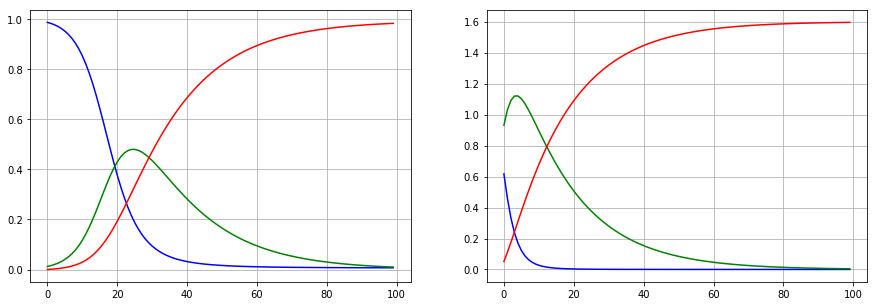

In [23]:
f, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(X_train[:, 0], 'b', label='S')
ax[0].plot(X_train[:, 1], 'g', label='I')
# ax[0].plot(X_train[:, 2], 'r', label='R')
ax[0].plot(X0_train.sum() - X_train[:, 0] - X_train[:, 1], 'r', label='R')

ax[0].grid()

ax[1].plot(X_test[:, 0], 'b', label='S')
ax[1].plot(X_test[:, 1], 'g', label='I')
ax[1].plot(X0_test.sum() - X_test[:, 0] - X_test[:, 1], 'r', label='R')
ax[1].grid()

plt.show()

As train data we will use only data in the left figure. The neural networks will be trained on it and then asked to predict dynamics in different parameter spaces (right figure). 

We will use 3 different architectures of neural networks for this purpose: Lie transform based network, Multilayer perceptron, and LSTM. We will predict the dynamics of state vector X[i] –> X[i+1], so we need 2 dimensions for input and output.

In [24]:
def createLieNet(inputDim, outputDim, order=3):
    model = Sequential()
    model.add(LieLayer(output_dim = outputDim, order=order,
                      input_shape = (inputDim,)))
    opt = keras.optimizers.Adamax(lr=0.02, beta_1=0.99,
                                  beta_2=0.99999, epsilon=1e-1, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model


def createMLP(inputDim, outputDim):
    model = Sequential()
    model.add(Dense(4, input_dim=inputDim, init='uniform', activation='sigmoid'))
    model.add(Dense(4, init='uniform', activation='sigmoid'))
    model.add(Dense(outputDim, init='uniform', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model


def createLSTM(inputDim, outputDim):
    model = Sequential()
    model.add(LSTM(10, input_dim=inputDim, input_length=1))
    model.add(Dense(outputDim, init='uniform', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model


lie = createLieNet(2,2)
mlp = createMLP(2,2)
lstm = createLSTM(2,2)

num_epoch = 1000
lie.fit(X_train[:-1], X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('Lie transform is built')
mlp.fit(X_train[:-1], X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('MLP is built')
lstm.fit(X_train[:-1].reshape((-1, 1, X_train.shape[1])), X_train[1:], nb_epoch=num_epoch, batch_size=50, verbose=0)
print('LSTM is built')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="sigmoid", kernel_initializer="uniform", input_dim=2)`
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="sigmoid", kernel_initializer="uniform")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="linear", kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(1, 2))`
/usr/local/lib/python2.7/dist

Lie transform is built
MLP is built
LSTM is built


To estimate dynamics in unknown space of initial points we will iteratively predict state vector starting from initial points

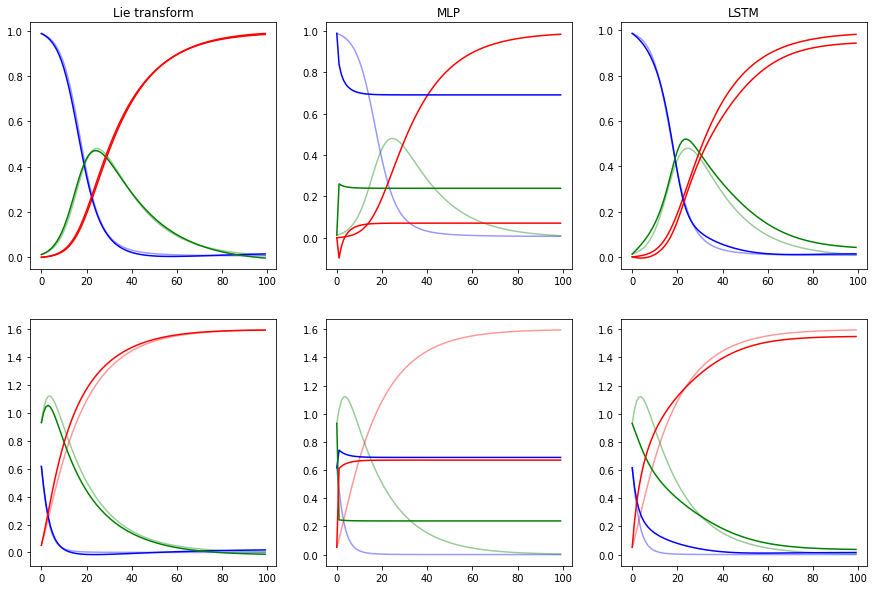

In [27]:
def iterative_predict(model, X0, N, reshape = False):
    ans = np.empty((N, len(X0)))
    X = X0.reshape(-1,len(X0))
    for i in xrange(N):
        if reshape:
            X = model.predict(X.reshape(1,1,len(X0)))
        else:
            X = model.predict(X)
        ans[i] = X
    return np.vstack((X0, ans[:-1]))


# draw true train and test data
f, ax = plt.subplots(2,3,figsize=(15,10))
for i in xrange(3):
    ax[0,i].plot(X_train[:, 0], 'b', label='S', alpha=0.4)
    ax[0,i].plot(X_train[:, 1], 'g', label='I', alpha=0.4)
    ax[0,i].plot(X0_train.sum() - X_train[:, 0] - X_train[:, 1], 'r', label='R')
    ax[0,i].grid()

    ax[1,i].plot(X_test[:, 0], 'b', label='S', alpha=0.4)
    ax[1,i].plot(X_test[:, 1], 'g', label='I', alpha=0.4)
    ax[1,i].plot(X0_test.sum() - X_test[:, 0] - X_test[:, 1], 'r', label='R', alpha=0.4)
    ax[1,i].grid()


# for k in xrange(3):
#     handles, labels = ax[1, k].get_legend_handles_labels()
#     ax[1, k].legend(handles, labels)

ax[0,0].set_title('Lie transform')
ax[0,1].set_title('MLP')
ax[0,2].set_title('LSTM')


# then predict via different neural networks
reshapes = [False, False, True]
for i, model in enumerate([lie, mlp, lstm]):
    X_train_predict= iterative_predict(model, X_train[0], N, reshape = reshapes[i])
    X_test_predict = iterative_predict(model, X_test[0], N, reshape  = reshapes[i])
    
    SUM = [X0_train.sum(), X0_test.sum()]
    for k, X_predict in enumerate([X_train_predict, X_test_predict]):
        ax[k,i].plot(X_predict[:, 0], 'b', label='S')
        ax[k,i].plot(X_predict[:, 1], 'g', label='I')
        ax[k,i].plot(SUM[k] - X_predict[:, 0] - X_predict[:, 1], 'r', label='R')
        ax[k,i].grid()
    
    
plt.show()

As one can see Lie transform generalizes nonlinear dynamics and can predict the behavior of the system. Both LSTM and MLP tend to memorize a training solution and attract all other points to the given train data.